In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Fill missing 'Age' values with median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

In [4]:
# Fill missing 'Embarked' with mode
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

In [5]:
# Drop 'Cabin' due to high number of missing values
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

Removing Duplicates

In [6]:
# Check for duplicates
print("\nDuplicates in Training Set:", train_df.duplicated().sum())
print("Duplicates in Test Set:", test_df.duplicated().sum())


Duplicates in Training Set: 0
Duplicates in Test Set: 0


In [7]:
# Remove duplicates if any
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [8]:
# Convert 'PassengerId' to string if necessary
train_df['PassengerId'] = train_df['PassengerId'].astype(str)
test_df['PassengerId'] = test_df['PassengerId'].astype(str)


Feature Engineering

In [9]:
# Extract Title from Name
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                              'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

In [10]:
# Encode 'Title'
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title'] = test_df['Title'].map(title_mapping)

# Fill missing titles with 0
train_df['Title'].fillna(0, inplace=True)
test_df['Title'].fillna(0, inplace=True)

In [11]:
# Create FamilySize
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

In [12]:
# Create IsAlone
train_df['IsAlone'] = 1  # Initialize to 1 (meaning alone)
train_df.loc[train_df['FamilySize'] > 1, 'IsAlone'] = 0

test_df['IsAlone'] = 1
test_df.loc[test_df['FamilySize'] > 1, 'IsAlone'] = 0

In [14]:
# Fare Binning
train_df['FareBin'] = pd.qcut(train_df['Fare'], 4, labels=[1, 2, 3, 4])
test_df['FareBin'] = pd.qcut(test_df['Fare'], 4, labels=[1, 2, 3, 4])

In [15]:
# Age Binning
train_df['AgeBin'] = pd.cut(train_df['Age'].astype(int), 5, labels=[1, 2, 3, 4, 5])
test_df['AgeBin'] = pd.cut(test_df['Age'].astype(int), 5, labels=[1, 2, 3, 4, 5])


In [16]:
# Encode 'Sex'
train_df['Sex_encoded'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex_encoded'] = test_df['Sex'].map({'male': 0, 'female': 1})

# One-hot encode 'Embarked'
embarked_dummies_train = pd.get_dummies(train_df['Embarked'], prefix='Embarked')
train_df = pd.concat([train_df, embarked_dummies_train], axis=1)

embarked_dummies_test = pd.get_dummies(test_df['Embarked'], prefix='Embarked')
test_df = pd.concat([test_df, embarked_dummies_test], axis=1)

In [17]:
# Drop original 'Name', 'Sex', and 'Embarked' columns
train_df.drop(['Name', 'Sex', 'Embarked'], axis=1, inplace=True)
test_df.drop(['Name', 'Sex', 'Embarked'], axis=1, inplace=True)

Data Transformation

In [18]:
# Initialize scaler
scaler = StandardScaler()

# Select features to scale
features_to_scale = ['Age', 'Fare', 'FamilySize']

# Fit and transform the features
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

# Verify scaling
print("\nScaled numerical features:")
print(train_df[features_to_scale].head())


Scaled numerical features:
        Age      Fare  FamilySize
0 -0.565736 -0.502445    0.059160
1  0.663861  0.786845    0.059160
2 -0.258337 -0.488854   -0.560975
3  0.433312  0.420730    0.059160
4  0.433312 -0.486337   -0.560975


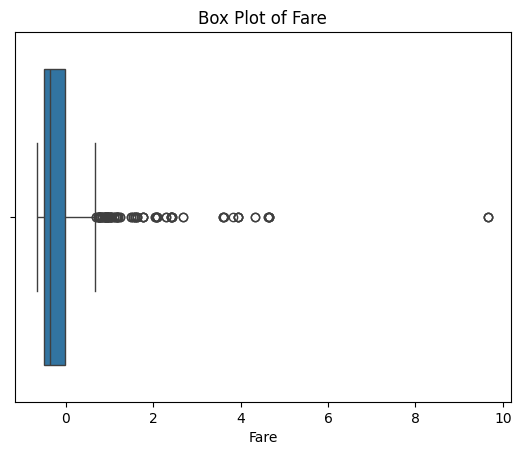

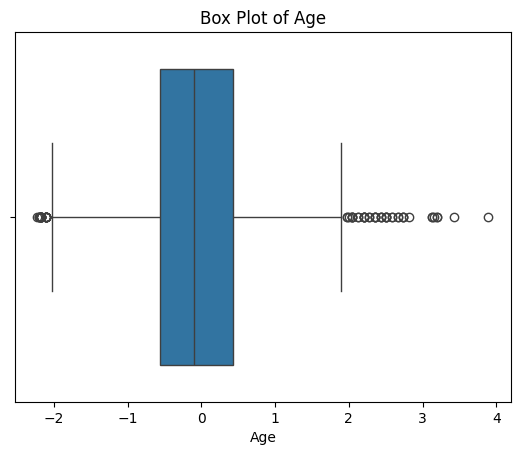

In [21]:
# Box plot for Fare
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=train_df['Fare'])
plt.title('Box Plot of Fare')
plt.show()

# Box plot for Age
sns.boxplot(x=train_df['Age'])
plt.title('Box Plot of Age')
plt.show()

# Handling outliers in 'Fare' using capping (IQR method)
Q1 = train_df['Fare'].quantile(0.25)
Q3 = train_df['Fare'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap 'Fare' values
train_df['Fare'] = np.where(train_df['Fare'] > upper_bound, upper_bound, train_df['Fare'])
test_df['Fare'] = np.where(test_df['Fare'] > upper_bound, upper_bound, test_df['Fare'])

# Handling outliers in 'Age' using capping (IQR method)
Q1_age = train_df['Age'].quantile(0.25)
Q3_age = train_df['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

# Cap 'Age' values
train_df['Age'] = np.where(train_df['Age'] > upper_bound_age, upper_bound_age, train_df['Age'])
test_df['Age'] = np.where(test_df['Age'] > upper_bound_age, upper_bound_age, test_df['Age'])


Splitting the data

In [22]:
# Define target and features
X = train_df.drop(['PassengerId', 'Survived'], axis=1)
y = train_df['Survived']

In [23]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set size:", X_train.shape)
print("Validation set size:", X_val.shape)


Training set size: (712, 15)
Validation set size: (179, 15)
